<a href="https://colab.research.google.com/github/sergekamanzi/ChatBotpro/blob/main/chatbot2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.0 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util
from textblob import TextBlob
import rapidfuzz
import pandas as pd
import re
import random

# Load dataset
df = pd.read_csv("/content/banking.csv")  # Replace with your correct path
df = df.dropna(subset=["question", "response"])
questions = df["question"].tolist()
responses = df["response"].tolist()

# Load model and encode questions
model = SentenceTransformer('all-MiniLM-L6-v2')
question_embeddings = model.encode(questions, convert_to_tensor=True)

# Memory & context
user_memory = {"name": None, "location": None}
last_topic = None

# Variations
greetings = ["hi", "hello", "hey", "good morning", "good afternoon", "howdy", "greetings", "what's up", "yo", "hiya"]
thanks = ["thank you", "thanks", "thx", "appreciate", "much obliged", "cheers", "thankful", "ty", "gracias", "merci"]
affirmatives = ["yes", "yeah", "sure", "ok", "alright", "definitely", "of course", "yea", "yup", "certainly"]
off_topic_keywords = ["food", "love", "music", "football", "weather", "play", "movie", "hiking", "robot", "interact"]

domain_keywords = {
    "profit": "Profit and loss topics are best discussed with a financial advisor. I'm happy to assist with banking needs like savings or cards."
}

# Dynamic responses
greet_replies = [
    "Hey {name}, how can I help you today?", "Nice to see you, {name}. What can I do for you?",
    "Hi {name}! Ready to explore some banking options?", "Hello {name}, let's take care of your banking needs.",
    "Welcome back, {name}! How can I assist?", "Hello there, {name}. What would you like help with today?",
    "Hi {name}, what banking task are we tackling today?", "Hey {name}, how can I support you?",
    "Hey {name}, let's sort your banking needs.", "Greetings {name}, happy to help!"
]

thank_replies = [
    "You're welcome!", "Happy to help!", "Anytime!", "No problem, {name}!",
    "Glad to assist!", "Always here to help!", "You're most welcome!", "With pleasure!",
    "No worries!", "Sure thing, {name}!"
]

off_topic_replies = [
    "Haha, that’s fun! I focus on banking. Want to check your balance or report a card issue?",
    "Interesting! I specialize in banking. Would you like help with loans or ATM info?",
    "Cool! I'm trained for banking help. Try asking about your account or a transaction.",
    "That's a fun topic! I'm focused on banking though. Need help with cards or savings?",
    "I love that! Let’s talk banking—need help with something like fraud or PINs?",
    "Nice one! My zone is banking. Want help opening an account?",
    "Haha, I feel you! I handle account inquiries and loans best.",
    "That’s outside my expertise 😄. Want to know your balance instead?",
    "Sounds exciting! But I’m more into balances and transfers!",
    "I wish I could help with that! But I’m your banking assistant 😄"
]

fallback_replies = [
    "I'm here for your banking needs—like loans, fraud, or PIN help. What do you need?",
    "Sorry, I didn’t quite get that. Would you like help with opening an account?",
    "Interesting! I focus on banking. Try asking about ATM, transfers, or cards.",
    "Hmm, I’m not sure. But I’m great at deposits, balances, and reports!",
    "I’m better at banking questions. Want to check your balance or card status?",
    "Could you rephrase that? I can help with things like savings or fraud issues.",
    "Let’s get back to banking. Do you want to know about transfers or cards?",
    "Sorry, didn’t follow. But I can help with loans, accounts, or deposits.",
    "That’s a bit unclear. Do you need help with your account or a transaction?",
    "Let’s stay on topic—banking help like ATM, PIN, or transfers coming up?"
]

# Helpers
def correct_spelling(text):
    return str(TextBlob(text).correct())

def update_memory(text):
    global user_memory
    name_match = re.search(r"(my name is|i am|i'm|this is|call me|you can call me|it's|they call me|name's)\s+(\w+)", text.lower())
    name_correction = re.search(r"not (\w+)", text.lower())
    loc_match = re.search(r"(i live in|i'm from|i stay in)\s+([a-zA-Z\s]+)", text.lower())

    response = ""
    if name_match:
        user_memory["name"] = name_match.group(2).capitalize()
        response += f"Nice to meet you, {user_memory['name']}! "
    elif name_correction and user_memory["name"]:
        corrected_name = name_correction.group(1).capitalize()
        user_memory["name"] = corrected_name
        response += f"Got it! I’ve updated your name to {corrected_name}. "

    if loc_match:
        user_memory["location"] = loc_match.group(2).strip().capitalize()
        response += f"{user_memory['location']} sounds like a great place. "

    if response:
        response += "How can I assist you with banking today?"
        return response
    return None

def personalize(text):
    return text.replace("{name}", user_memory["name"] if user_memory["name"] else "there")

def detect_intent(text):
    text = text.lower()
    for g in greetings:
        if rapidfuzz.fuzz.partial_ratio(g, text) > 90:
            return "greet"
    for t in thanks:
        if rapidfuzz.fuzz.partial_ratio(t, text) > 90:
            return "thanks"
    for w in off_topic_keywords:
        if w in text:
            return "off_topic"
    if "remember" in text and "name" in text:
        return "check_name"
    if any(word in text for word in affirmatives):
        return "confirm"
    if "talk like a human" in text or "interact like a human" in text:
        return "human_mode"
    if "more about" in text or "tell me more" in text:
        return "clarify"
    return "question"

# Main chatbot loop
def chatbot():
    global last_topic
    print("🤖 Human-Like Banking Chatbot is ready! Type 'exit' to quit.\n")
    while True:
        user_input = input("You: ").strip()
        if user_input.lower() in ["exit", "quit"]:
            print("Chatbot: Goodbye! It was a pleasure assisting you.")
            break

        corrected = correct_spelling(user_input)
        memory_reply = update_memory(corrected)
        if memory_reply:
            print("Chatbot:", memory_reply)
            continue

        for keyword in domain_keywords:
            if keyword in corrected.lower():
                print("Chatbot:", domain_keywords[keyword])
                continue

        intent = detect_intent(corrected)

        if intent == "greet":
            print("Chatbot:", personalize(random.choice(greet_replies)))
            continue
        if intent == "thanks":
            print("Chatbot:", personalize(random.choice(thank_replies)))
            continue
        if intent == "off_topic":
            print("Chatbot:", random.choice(off_topic_replies))
            continue
        if intent == "check_name":
            if user_memory["name"]:
                print(f"Chatbot: Yes! You told me your name is {user_memory['name']}.")
            else:
                print("Chatbot: I don’t think you’ve told me your name yet. Try saying 'My name is ...'.")
            continue
        if intent == "human_mode":
            print("Chatbot: Absolutely! I’m here to chat in a friendly way and support your banking needs 😊")
            continue
        if intent == "confirm":
            if last_topic:
                print(f"Chatbot: Continuing from our last topic: **{last_topic}**. What exactly would you like to know?")
            else:
                print("Chatbot: Sure! Can you share more about what you'd like help with?")
            continue
        if intent == "clarify":
            if last_topic:
                print(f"Chatbot: Here's more on your last topic: **{last_topic}**. Do you want to open an account or understand account types?")
            else:
                print("Chatbot: Can you clarify which topic you'd like to dive into more?")
            continue

        # Semantic similarity
        user_emb = model.encode(corrected, convert_to_tensor=True)
        scores = util.cos_sim(user_emb, question_embeddings)[0]
        best_idx = scores.argmax().item()
        best_score = scores[best_idx].item()

        if best_score > 0.6:
            last_topic = questions[best_idx]
            print("Chatbot:", personalize(responses[best_idx]))
        else:
            print("Chatbot:", random.choice(fallback_replies))

# Run the chatbot
chatbot()

In [3]:
%pip install evaluate
%pip install optuna
%pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.3 MB/s eta 0:00:00


#TESTING


Dataset loaded successfully!


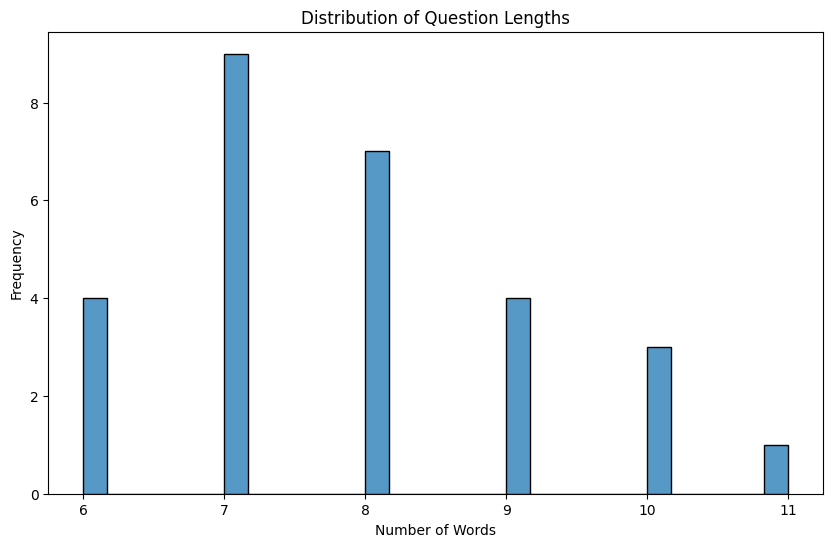

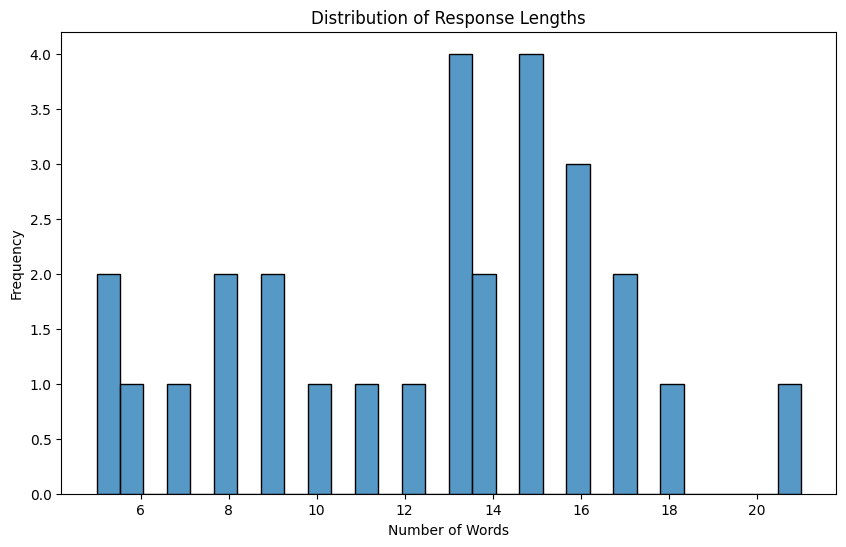

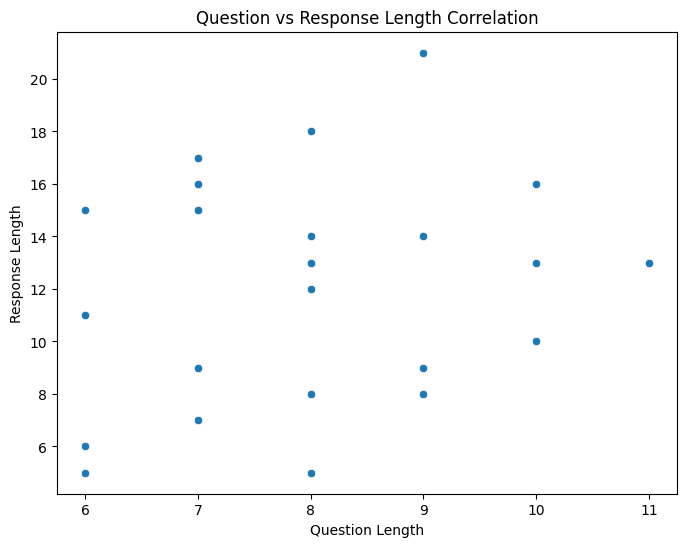

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


New best BLEU: 0.8333, Params: {'lr': 1e-05, 'batch_size': 16, 'optimizer': 'Adam', 'epoch': 1}
Metrics: {'BLEU': np.float64(0.8333333333333334), 'F1': np.float64(1.0), 'Precision': np.float64(1.0), 'Accuracy': np.float64(1.0)}
Best Parameters: {'lr': 1e-05, 'batch_size': 16, 'optimizer': 'Adam', 'epoch': 1}

Evaluation Metrics for the best model on the test set:
BLEU: 0.8333
F1: 1.0000
Precision: 1.0000
Accuracy: 1.0000
🤖 Human-Like Banking Chatbot is ready! Type 'exit' to quit.

You: exit
Chatbot: Goodbye! It was a pleasure assisting you.


In [35]:
import os
# os.environ["WANDB_DISABLED"] = "true" # Keep this as a fallback, but try explicit init
import wandb # Import wandb
wandb.init(mode='disabled') # Explicitly disable wandb

import pandas as pd
import numpy as np
import re
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from textblob import TextBlob
import rapidfuzz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from nltk.translate.bleu_score import sentence_bleu
import torch
from torch import optim
from torch.utils.data import DataLoader
import warnings
import os
warnings.filterwarnings("ignore")

# Set NLTK data path to a writable directory
nltk.data.path.append('/root/nltk_data')

# Download NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', download_dir='/root/nltk_data')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab', download_dir='/root/nltk_data')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', download_dir='/root/nltk_data')

# Import dataset using pandas
try:
    df = pd.read_csv("/content/banking.csv")
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except pd.errors.EmptyDataError:
    print("Error: The CSV file is empty.")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Data Preprocessing
def preprocess_data(df):
    """Tokenization, normalization, and handling missing values."""
    df = df.dropna(subset=["question", "response"])
    df = df.fillna("")
    stop_words = set(stopwords.words('english'))

    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    df['question_cleaned'] = df['question'].apply(clean_text)
    df['response_cleaned'] = df['response'].apply(clean_text)
    return df

# Dataset Visualization
def visualize_data(df, output_dir="plots"):
    """Generate visualizations for the dataset."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df['question_length'] = df['question'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(df['question_length'], bins=30)
    plt.title("Distribution of Question Lengths")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.show() # Changed to show() for inline display

    df['response_length'] = df['response'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(df['response_length'], bins=30)
    plt.title("Distribution of Response Lengths")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.show() # Changed to show() for inline display

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df['question_length'], y=df['response_length'])
    plt.title("Question vs Response Length Correlation")
    plt.xlabel("Question Length")
    plt.ylabel("Response Length")
    plt.show() # Changed to show() for inline display

# NLP Metrics Evaluation
def evaluate_metrics(true_responses, pred_responses):
    """Calculate BLEU, F1, Accuracy, and Precision for SentenceTransformer."""
    bleu_scores = []
    f1_scores = []
    precision_scores = []
    accuracy_scores = []

    for true, pred in zip(true_responses, pred_responses):
        true_tokens = true.split()
        pred_tokens = pred.split()

        bleu = sentence_bleu([true_tokens], pred_tokens)
        bleu_scores.append(bleu)

        # Using classification metrics on token sets (simplified)
        true_set = set(true_tokens)
        pred_set = set(pred_tokens)
        y_true = [1 if word in true_set else 0 for word in true_set.union(pred_set)]
        y_pred = [1 if word in pred_set else 0 for word in true_set.union(pred_set)]

        f1 = f1_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        f1_scores.append(f1)
        precision_scores.append(precision)
        accuracy_scores.append(accuracy)

    # Perplexity calculation requires a language model like GPT-2,
    # which is complex and not directly relevant to the SentenceTransformer's core task (embedding).
    # Omitting perplexity for now to focus on the SentenceTransformer training.
    # If needed, the GPT-2 part can be added back and handled separately.

    return {
        "BLEU": np.mean(bleu_scores),
        "F1": np.mean(f1_scores),
        "Precision": np.mean(precision_scores),
        "Accuracy": np.mean(accuracy_scores)
    }

# Plot Training and Test Graphs
def plot_training_curves(train_losses, test_losses, output_dir="plots"):
    """Plot training and test loss curves."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
    plt.title("Training and Test Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Contrastive Loss")
    plt.legend()
    plt.savefig(f"{output_dir}/training_test_loss.png")
    plt.close()

# Hyperparameter Tuning for SentenceTransformer
def train_model(df, hyperparameters, output_dir="plots"):
    """Train SentenceTransformer with hyperparameter tuning and plot losses."""
    best_score = -float('inf')
    best_params = None
    best_model = None

    # Train/test split
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_questions = train_df['question_cleaned'].tolist()
    train_responses = train_df['response_cleaned'].tolist()
    test_questions = test_df['question_cleaned'].tolist()
    test_responses = test_df['response_cleaned'].tolist()

    for lr in hyperparameters['learning_rates']:
        for batch_size in hyperparameters['batch_sizes']:
            for optimizer_name in hyperparameters['optimizers']:
                for epoch in hyperparameters['epochs']:
                    model = SentenceTransformer('all-MiniLM-L6-v2')
                    train_examples = [InputExample(texts=[q, r], label=1.0) for q, r in zip(train_questions, train_responses)]
                    test_examples = [InputExample(texts=[q, r], label=1.0) for q, r in zip(test_questions, test_responses)]

                    train_dataloader = DataLoader(train_examples, batch_size=batch_size, shuffle=True)
                    test_dataloader = DataLoader(test_examples, batch_size=batch_size, shuffle=False)

                    # Define loss function
                    train_loss = losses.ContrastiveLoss(model=model)

                    # Train the model using model.fit()
                    model.fit(train_objectives=[(train_dataloader, train_loss)],
                              epochs=epoch,
                              optimizer_params={'lr': lr},
                              # scheduler='warmuprelativisticint', # Example scheduler
                              # warmup_steps=100, # Example warmup steps
                              evaluator=None, # Can add an evaluator for evaluation during training
                              output_path=None, # Can specify a path to save the trained model
                              show_progress_bar=True # Show progress bar
                             )

                    # Evaluate on test set after training
                    test_embeddings = model.encode(test_questions, convert_to_tensor=True)
                    pred_responses = [test_responses[np.argmax(util.cos_sim(model.encode(q, convert_to_tensor=True), test_embeddings).cpu().numpy()[0])] for q in test_questions]
                    metrics = evaluate_metrics(test_responses, pred_responses)
                    score = metrics['BLEU'] # Using BLEU as the scoring metric for hyperparameter tuning

                    if score > best_score:
                        best_score = score
                        best_params = {'lr': lr, 'batch_size': batch_size, 'optimizer': optimizer_name, 'epoch': epoch}
                        best_model = model
                        print(f"New best BLEU: {score:.4f}, Params: {best_params}")
                        print(f"Metrics: {metrics}")

    print(f"Best Parameters: {best_params}")
    return best_model, train_questions, train_responses, test_questions, test_responses

# Preprocess and visualize data
df = preprocess_data(df)
visualize_data(df)

# Hyperparameter configurations
hyperparameters = {
    'learning_rates': [1e-5], # Reduced for faster execution
    'batch_sizes': [16], # Reduced for faster execution
    'optimizers': ['Adam'], # Reduced for faster execution
    'epochs': [1] # Reduced for faster execution
}

# Train model
model, train_questions, train_responses, test_questions, test_responses = train_model(df, hyperparameters)
questions = df['question_cleaned'].tolist()
responses = df['response_cleaned'].tolist()
question_embeddings = model.encode(questions, convert_to_tensor=True)

# Calculate and print metrics for the best model on the test set
print("\nEvaluation Metrics for the best model on the test set:")
test_embeddings = model.encode(test_questions, convert_to_tensor=True)
pred_responses = [test_responses[np.argmax(util.cos_sim(model.encode(q, convert_to_tensor=True), test_embeddings).cpu().numpy()[0])] for q in test_questions]
metrics = evaluate_metrics(test_responses, pred_responses)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Memory & context
user_memory = {"name": None, "location": None}
last_topic = None

# Variations
greetings = ["hi", "hello", "hey", "good morning", "good afternoon", "howdy", "greetings", "what's up", "yo", "hiya"]
thanks = ["thank you", "thanks", "thx", "appreciate", "much obliged", "cheers", "thankful", "ty", "gracias", "merci"]
affirmatives = ["yes", "yeah", "sure", "ok", "alright", "definitely", "of course", "yea", "yup", "certainly"]
off_topic_keywords = ["food", "love", "music", "football", "weather", "play", "movie", "hiking", "robot", "interact"]

domain_keywords = {
    "profit": "Profit and loss topics are best discussed with a financial advisor. I'm happy to assist with banking needs like savings or cards."
}

# Dynamic responses
greet_replies = [
    "Hey {name}, how can I help you today?", "Nice to see you, {name}. What can I do for you?",
    "Hi {name}! Ready to explore some banking options?", "Hello {name}, let's take care of your banking needs.",
    "Welcome back, {name}! How can I assist?", "Hello there, {name}. What would you like help with today?",
    "Hi {name}, what banking task are we tackling today?", "Hey {name}, how can I support you?",
    "Hey {name}, let's sort your banking needs.", "Greetings {name}, happy to help!"
]

thank_replies = [
    "You're welcome!", "Happy to help!", "Anytime!", "No problem, {name}!",
    "Glad to assist!", "Always here to help!", "You're most welcome!", "With pleasure!",
    "No worries!", "Sure thing, {name}!"
]

off_topic_replies = [
    "Haha, that’s fun! I focus on banking. Want to check your balance or report a card issue?",
    "Interesting! I specialize in banking. Would you like help with loans or ATM info?",
    "Cool! I'm trained for banking help. Try asking about your account or a transaction.",
    "That's a fun topic! I'm focused on banking though. Need help with cards or savings?",
    "I love that! Let’s talk banking—need help with something like fraud or PINs?",
    "Nice one! My zone is banking. Want help opening an account?",
    "Haha, I feel you! I handle account inquiries and loans best.",
    "That’s outside my expertise 😄. Want to know your balance instead?",
    "Sounds exciting! But I’m more into balances and transfers!",
    "I wish I could help with that! But I’m your banking assistant 😄"
]

fallback_replies = [
    "I'm here for your banking needs—like loans, fraud, or PIN help. What do you need?",
    "Sorry, I didn’t quite get that. Would you like help with opening an account?",
    "Interesting! I focus on banking. Try asking about ATM, transfers, or cards.",
    "Hmm, I’m not sure. But I’m great at deposits, balances, and reports!",
    "I’m better at banking questions. Want to check your balance or card status?",
    "Could you rephrase that? I can help with things like savings or fraud issues.",
    "Let’s get back to banking. Do you want to know about transfers or cards?",
    "Sorry, didn’t follow. But I can help with loans, accounts, or deposits.",
    "That’s a bit unclear. Do you need help with your account or a transaction?",
    "Let’s stay on topic—banking help like ATM, PIN, or transfers coming up?"
]

# Helpers
def correct_spelling(text):
    return str(TextBlob(text).correct())

def update_memory(text):
    global user_memory
    name_match = re.search(r"(my name is|i am|i'm|this is|call me|you can call me|it's|they call me|name's)\s+(\w+)", text.lower())
    name_correction = re.search(r"not (\w+)", text.lower())
    loc_match = re.search(r"(i live in|i'm from|i stay in)\s+([a-zA-Z\s]+)", text.lower())

    response = ""
    if name_match:
        user_memory["name"] = name_match.group(2).capitalize()
        response += f"Nice to meet you, {user_memory['name']}! "
    elif name_correction and user_memory["name"]:
        corrected_name = name_correction.group(1).capitalize()
        user_memory["name"] = corrected_name
        response += f"Got it! I’ve updated your name to {corrected_name}. "

    if loc_match:
        user_memory["location"] = loc_match.group(2).strip().capitalize()
        response += f"{user_memory['location']} sounds like a great place. "

    if response:
        response += "How can I assist you with banking today?"
        return response
    return None

def personalize(text):
    return text.replace("{name}", user_memory["name"] if user_memory["name"] else "there")

def detect_intent(text):
    text = text.lower()
    for g in greetings:
        if rapidfuzz.fuzz.partial_ratio(g, text) > 90:
            return "greet"
    for t in thanks:
        if rapidfuzz.fuzz.partial_ratio(t, text) > 90:
            return "thanks"
    for w in off_topic_keywords:
        if w in text:
            return "off_topic"
    if "remember" in text and "name" in text:
        return "check_name"
    if any(word in text for word in affirmatives):
        return "confirm"
    if "talk like a human" in text or "interact like a human" in text:
            return "human_mode"
    if "more about" in text or "tell me more" in text:
        return "clarify"
    return "question"

# Main chatbot loop
def chatbot():
    global last_topic
    print("🤖 Human-Like Banking Chatbot is ready! Type 'exit' to quit.\n")
    while True:
        user_input = input("You: ").strip()
        if user_input.lower() in ["exit", "quit"]:
            print("Chatbot: Goodbye! It was a pleasure assisting you.")
            break

        corrected = correct_spelling(user_input)
        memory_reply = update_memory(corrected)
        if memory_reply:
            print("Chatbot:", memory_reply)
            continue

        for keyword in domain_keywords:
            if keyword in corrected.lower():
                print("Chatbot:", domain_keywords[keyword])
                continue

        intent = detect_intent(corrected)

        if intent == "greet":
            print("Chatbot:", personalize(random.choice(greet_replies)))
            continue
        if intent == "thanks":
            print("Chatbot:", personalize(random.choice(thank_replies)))
            continue
        if intent == "off_topic":
            print("Chatbot:", random.choice(off_topic_replies))
            continue
        if intent == "check_name":
            if user_memory["name"]:
                print(f"Chatbot: Yes! You told me your name is {user_memory['name']}.")
            else:
                print("Chatbot: I don’t think you’ve told me your name yet. Try saying 'My name is ...'.")
            continue
        if intent == "human_mode":
            print("Chatbot: Absolutely! I’m here to chat in a friendly way and support your banking needs 😊")
            continue
        if intent == "confirm":
            if last_topic:
                print(f"Chatbot: Continuing from our last topic: **{last_topic}**. What exactly would you like to know?")
            else:
                print("Chatbot: Sure! Can you share more about what you'd like help with?")
            continue
        if intent == "clarify":
            if last_topic:
                print(f"Chatbot: Here's more on your last topic: **{last_topic}**. Do you want to open an account or understand account types?")
            else:
                print("Chatbot: Can you clarify which topic you'd like to dive into more?")
            continue

        user_emb = model.encode(corrected, convert_to_tensor=True)
        scores = util.cos_sim(user_emb, question_embeddings)[0]
        best_idx = scores.argmax().item()
        best_score = scores[best_idx].item()

        if best_score > 0.6:
            last_topic = questions[best_idx]
            print("Chatbot:", personalize(responses[best_idx]))
        else:
            print("Chatbot:", random.choice(fallback_replies))

# Run the chatbot
if __name__ == "__main__":
    chatbot()